# BASEBALL | Econ 430 Project #2

**Group members**: Leonardo Livio Fancello, Hayden Johnson, Cade Foster, Quentin Bidwell

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.outliers_influence as smo
import patsy as pt
import statsmodels.regression.linear_model as rg
import statsmodels.stats.diagnostic as dg
from RegscorePy import mallow
from BorutaShap import BorutaShap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from simple_colors import *

## VARIABLE SELECTION

In [2]:
ba = pd.read_csv("stats.csv")
ba.loc[ba['sprint_speed'] < ba.sprint_speed.mean(), 'AverageSpeed'] = 0
ba.loc[ba['sprint_speed'] > ba.sprint_speed.mean(), 'AverageSpeed'] = 1
ba.head()

,last_name,first_name,player_id,year,xba,xslg,xwoba,xobp,xiso,exit_velocity_avg,...,solidcontact_percent,avg_best_speed,avg_hyper_speed,z_swing_miss_percent,oz_swing_miss_percent,oz_contact_percent,hp_to_1b,sprint_speed,Unnamed: 21,AverageSpeed
0,Cruz Jr.,Nelson,443558,2022,0.241,0.399,0.320,0.323,0.157,90.9,...,4.5,102.298381,7.468978,23.3,50.6,49.4,4.81,25.5,NaN,0.0
1,Blackmon,Charlie,453568,2022,0.256,0.376,0.301,0.308,0.120,86.2,...,4.0,97.426435,4.732128,16.6,32.6,67.1,4.36,27.9,NaN,1.0
2,McCutchen,Andrew,457705,2022,0.252,0.406,0.325,0.329,0.155,89.1,...,5.8,99.926933,6.143161,16.8,49.2,50.8,4.38,28.9,NaN,1.0
3,Turner,Justin,457759,2022,0.267,0.427,0.339,0.343,0.160,89.5,...,6.2,99.002546,5.736859,16.1,31.1,68.9,4.87,25.0,NaN,0.0
4,Andrus,Elvis,462101,2022,0.245,0.360,0.293,0.300,0.114,87.9,...,3.6,98.336004,5.236648,14.2,36.2,63.8,4.60,26.0,NaN,0.0


### The best 10 predictors

  0%|          | 0/50 [00:00<?, ?it/s]

7 attributes confirmed important: ['sweet_spot_percent', 'xwoba', 'xobp', 'xslg', 'z_swing_miss_percent', 'launch_angle_avg', 'oz_swing_miss_percent']
6 attributes confirmed unimportant: ['barrel_batted_rate', 'xiso', 'solidcontact_percent', 'avg_hyper_speed', 'exit_velocity_avg', 'avg_best_speed']
0 tentative attributes remains: []


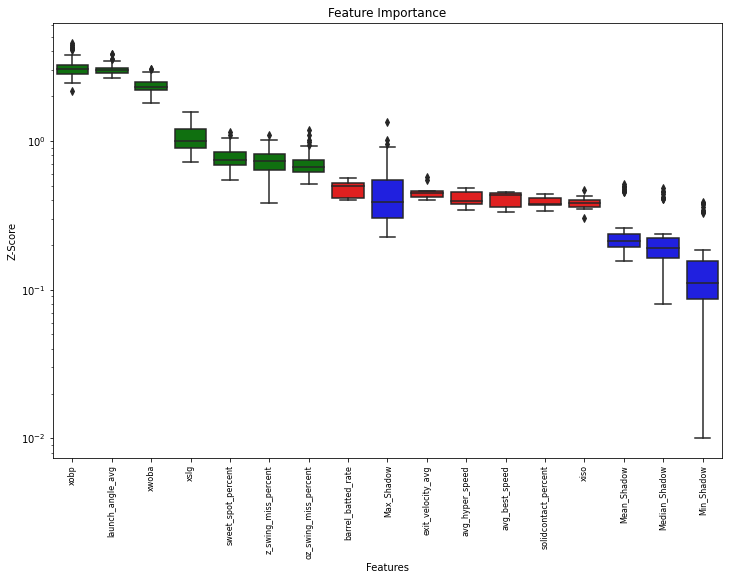

In [4]:
x = ba.iloc[:,5:18]
y = ba['xba']

Feature_Selector = BorutaShap(importance_measure='shap', classification=False)
Feature_Selector.fit(X=x, y=y, n_trials=50, random_state=0)
Feature_Selector.plot(which_features='all')

### Predictors selection

In [3]:
mr_mod = smf.ols(formula = 'xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data = ba)
mr_fit = mr_mod.fit()
mr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     76.53
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           1.32e-41
Time:                        14:55:38   Log-Likelihood:                 424.69
No. Observations:                 130   AIC:                            -833.4
Df Residuals:                     122   BIC:                            -810.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1351      0.016      8.614      0.000       0.104       0.166
xobp                     0.5632      0.218      2.585      0.011       0.132       0.994
launch_angle_avg        -0.0021      0.000     -9.916      0.000      -0.003      -0.002
xwoba                   -0.7886      0.406     -1.944      0.054      -1.592       0.014
xslg                     0.4398      0.132      3.340      0.001       0.179       0.700
sweet_spot_percent       0.0017      0.000      5.976      0.000       0.001       0.002
z_swing_miss_percent    -0.0014      0.000     -6.270      0.000      -0.002      -0.001
AverageSpeed             0.0018      0.002      1.021      0.309      -0.002       0.005
==============================================================================
Omnibus:                        4.346   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                2.860
Skew:                          -0.183   Prob(JB):                        0.239
Kurtosis:                       2.372   Cond. No.                     2.30e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## DESCRIPTIVE ANALYSIS

### Basic analysis

In [26]:
ba.isnull().sum()

last_name                  0
 first_name                0
player_id                  0
year                       0
xba                        0
xslg                       0
xwoba                      0
xobp                       0
xiso                       0
exit_velocity_avg          0
launch_angle_avg           0
sweet_spot_percent         0
barrel_batted_rate         0
solidcontact_percent       0
avg_best_speed             0
avg_hyper_speed            0
z_swing_miss_percent       0
oz_swing_miss_percent      0
oz_contact_percent         0
hp_to_1b                   0
sprint_speed               0
Unnamed: 21              130
AverageSpeed               0
dtype: int64

In [4]:
ba = ba.drop(['Unnamed: 21'], axis=1)

We are dropping the column *Unnamed: 21* as it is a column made of all NULL values.

In [4]:
ba.describe()

,player_id,year,xba,xslg,xwoba,xobp,xiso,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,solidcontact_percent,avg_best_speed,avg_hyper_speed,z_swing_miss_percent,oz_swing_miss_percent,oz_contact_percent,hp_to_1b,sprint_speed,AverageSpeed
count,130.000000,130.0,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,607829.930769,2022.0,0.253931,0.420654,0.328285,0.327485,0.166792,89.330769,13.225385,34.118462,8.613077,6.508462,100.188403,6.376427,16.182308,39.565385,60.126154,4.470077,27.271538,0.515385
std,61551.798138,0.0,0.021504,0.061844,0.032098,0.029719,0.052620,2.097501,4.399688,3.354871,4.167247,1.624857,2.361774,1.394332,4.812089,8.663536,8.581326,0.195176,1.322157,0.501697
min,443558.000000,2022.0,0.188000,0.291000,0.267000,0.267000,0.065000,84.400000,3.000000,25.500000,0.700000,2.600000,93.050155,2.545714,5.500000,10.300000,38.100000,4.090000,23.900000,0.000000
25%,571987.750000,2022.0,0.240250,0.379250,0.306500,0.306000,0.135000,87.800000,10.100000,31.800000,6.000000,5.425000,98.645463,5.371013,13.525000,34.225000,54.250000,4.332500,26.400000,0.000000
50%,622163.500000,2022.0,0.254500,0.416000,0.326000,0.327000,0.158000,89.400000,12.900000,34.100000,8.200000,6.500000,100.281855,6.422282,16.050000,39.500000,60.100000,4.455000,27.300000,1.000000
75%,663574.000000,2022.0,0.266750,0.454000,0.346500,0.342000,0.205500,90.650000,16.100000,36.375000,11.050000,7.475000,101.634860,7.150323,19.700000,45.300000,65.750000,4.610000,28.275000,1.000000
max,683734.000000,2022.0,0.329000,0.706000,0.463000,0.430000,0.401000,95.900000,21.700000,42.900000,26.500000,10.300000,107.110073,11.053359,27.500000,61.600000,89.700000,5.010000,30.400000,1.000000


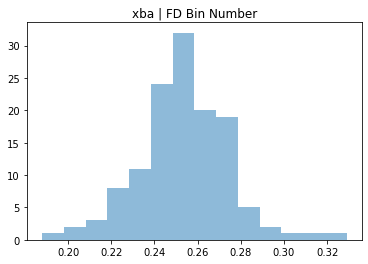

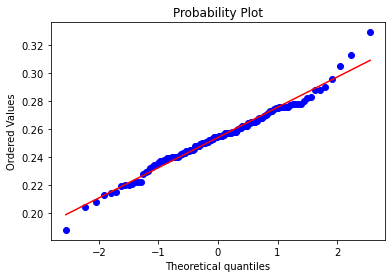

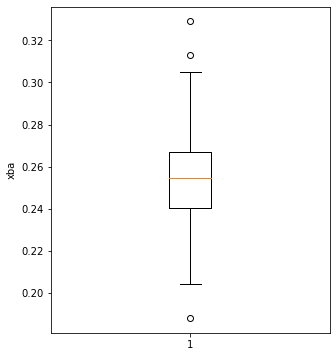

In [14]:
plt.hist(ba.xba, alpha = .5, bins = "fd")
plt.title("xba | FD Bin Number")
plt.show()
stats.probplot(ba.xba, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(ba.xba)
plt.ylabel("xba")
plt.show()

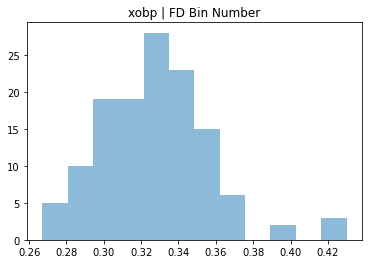

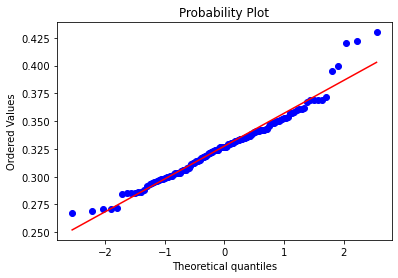

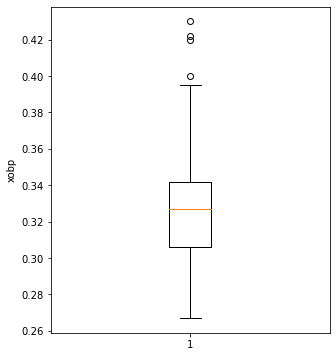

In [15]:
plt.hist(ba.xobp, alpha = .5, bins = "fd")
plt.title("xobp | FD Bin Number")
plt.show()
stats.probplot(ba.xobp, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(ba.xobp)
plt.ylabel("xobp")
plt.show()

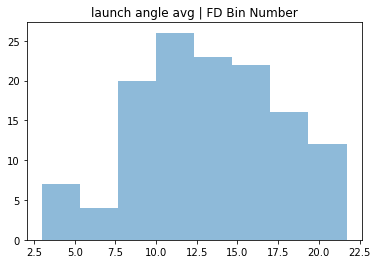

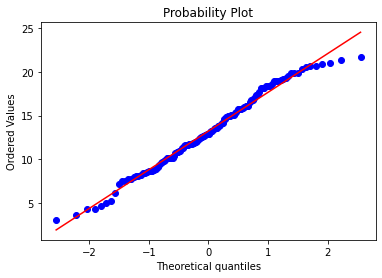

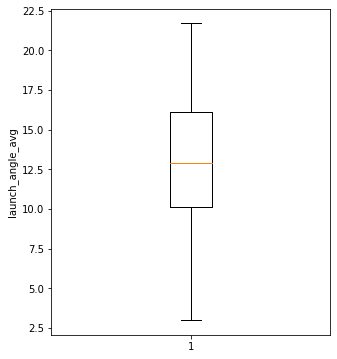

In [16]:
plt.hist(ba.launch_angle_avg, alpha = .5, bins = "fd")
plt.title("launch angle avg | FD Bin Number")
plt.show()
stats.probplot(ba.launch_angle_avg, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(ba.launch_angle_avg)
plt.ylabel("launch_angle_avg")
plt.show()

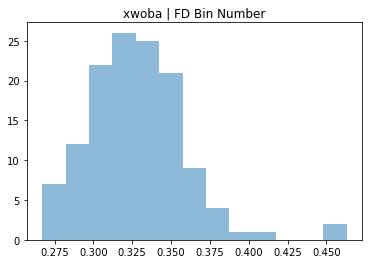

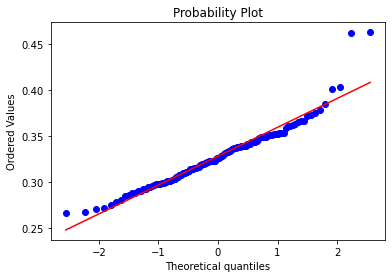

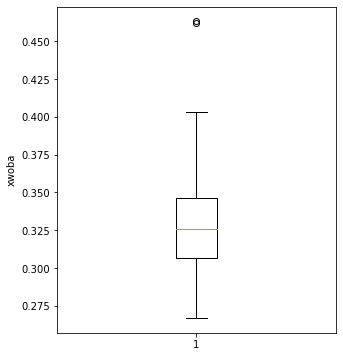

In [17]:
plt.hist(ba.xwoba, alpha = .5, bins = "fd")
plt.title("xwoba | FD Bin Number")
plt.show()
stats.probplot(ba.xwoba, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(ba.xwoba)
plt.ylabel("xwoba")
plt.show()

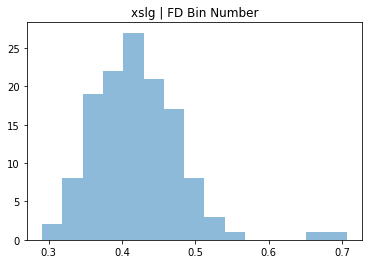

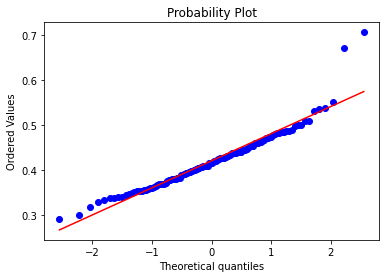

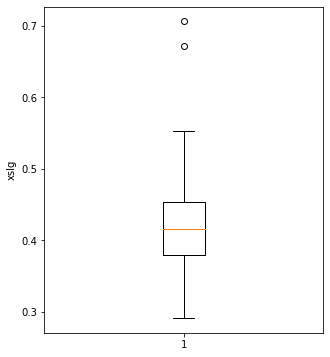

In [18]:
plt.hist(ba.xslg, alpha = .5, bins = "fd")
plt.title("xslg | FD Bin Number")
plt.show()
stats.probplot(ba.xslg, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(ba.xslg)
plt.ylabel("xslg")
plt.show()

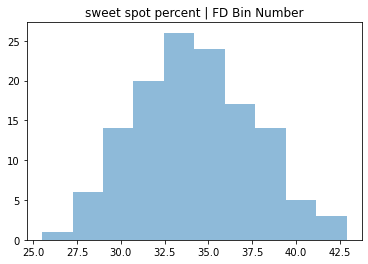

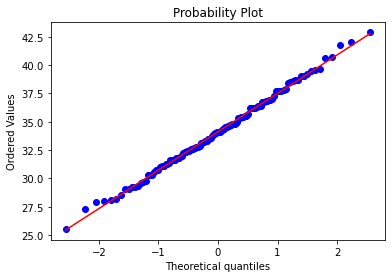

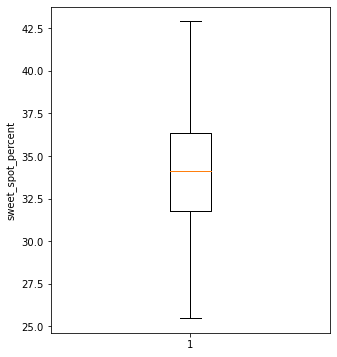

In [19]:
plt.hist(ba.sweet_spot_percent, alpha = .5, bins = "fd")
plt.title("sweet spot percent | FD Bin Number")
plt.show()
stats.probplot(ba.sweet_spot_percent, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(ba.sweet_spot_percent)
plt.ylabel("sweet_spot_percent")
plt.show()

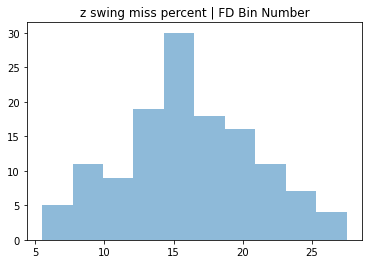

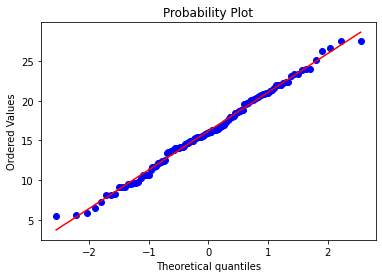

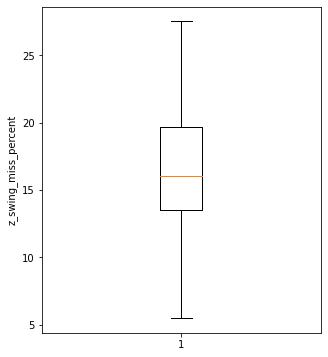

In [20]:
plt.hist(ba.z_swing_miss_percent, alpha = .5, bins = "fd")
plt.title("z swing miss percent | FD Bin Number")
plt.show()
stats.probplot(ba.z_swing_miss_percent, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(ba.z_swing_miss_percent)
plt.ylabel("z_swing_miss_percent")
plt.show()

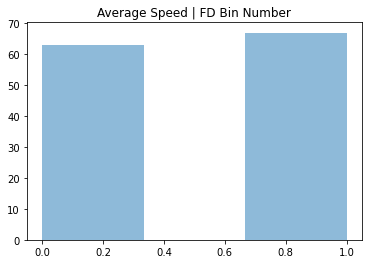

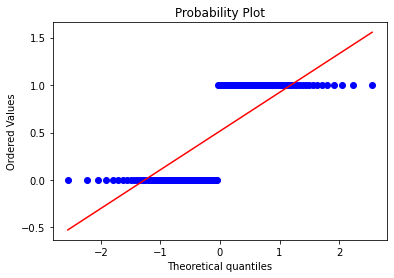

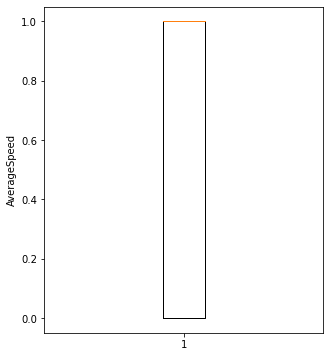

In [21]:
plt.hist(ba.AverageSpeed, alpha = .5, bins = "fd")
plt.title("Average Speed | FD Bin Number")
plt.show()
stats.probplot(ba.AverageSpeed, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(ba.AverageSpeed)
plt.ylabel("AverageSpeed")
plt.show()

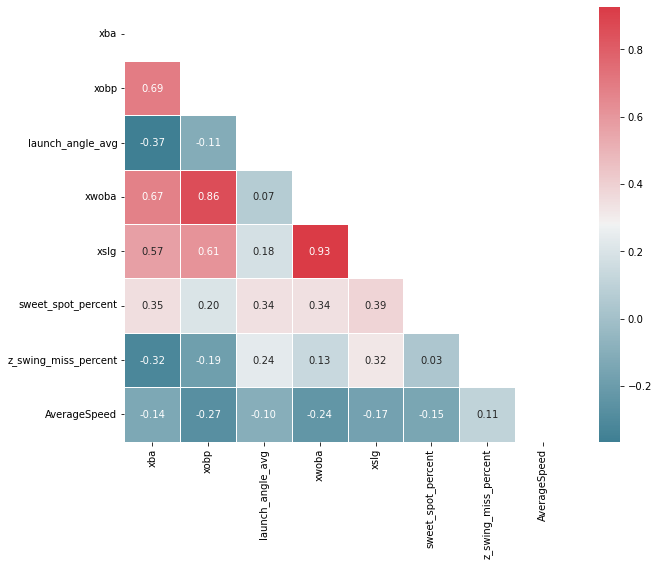

In [22]:
#correlation plot of all dependant variables
sub_df =  ba[["xba", "xobp", "launch_angle_avg", "xwoba", "xslg", "sweet_spot_percent", "z_swing_miss_percent", "AverageSpeed"]]
corr = sub_df.corr()
fig, ax = plt.subplots(figsize=(10, 8))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
dropvals = np.zeros_like(corr)
dropvals[np.triu_indices_from(dropvals)] = True
sns.heatmap(corr, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals)
plt.show()

### Density plots

In [12]:
sns.histplot(ba.xba, stat="density")
sns.kdeplot(ba.xba, color="red")
plt.title("Density of Expected Batting Average")
plt.xlabel("Expected Batting Average")
plt.ylabel("Density")
plt.grid()
plt.savefig("xba.jpg")
plt.close()

sns.histplot(ba.xobp, stat="density")
sns.kdeplot(ba.xobp, color="red")
plt.title("Density of Expected On-base Percentage")
plt.xlabel("Expected On-base Percentage")
plt.ylabel("Density")
plt.grid()
plt.savefig("xobp.jpg")
plt.close()

sns.histplot(ba.launch_angle_avg, stat="density")
sns.kdeplot(ba.launch_angle_avg, color="red")
plt.title("Density of Launch Angle Avg")
plt.xlabel("Launch Angle Avg")
plt.ylabel("Density")
plt.grid()
plt.savefig("launch_angle_avg.jpg")
plt.close()

sns.histplot(ba.xwoba, stat="density")
sns.kdeplot(ba.xwoba, color="red")
plt.title("Density of Expected Weighted On-base Avg")
plt.xlabel("Expected Weighted On-base Avg")
plt.ylabel("Density")
plt.grid()
plt.savefig("xwoba.jpg")
plt.close()

sns.histplot(ba.xslg, stat="density")
sns.kdeplot(ba.xslg, color="red")
plt.title("Density of Expected Slugging Percentage")
plt.xlabel("Expected Slugging Percentage")
plt.ylabel("Density")
plt.grid()
plt.savefig("xlsg.jpg")
plt.close()

sns.histplot(ba.sweet_spot_percent, stat="density")
sns.kdeplot(ba.sweet_spot_percent, color="red")
plt.title("Density of Sweet Spot Percentage")
plt.xlabel("Sweet Spot Percentage")
plt.ylabel("Density")
plt.grid()
plt.savefig("sweet_spot_percent.jpg")
plt.close()

sns.histplot(ba.z_swing_miss_percent, stat="density")
sns.kdeplot(ba.z_swing_miss_percent, color="red")
plt.title("Density of Swing Miss Percentage")
plt.xlabel("Swing Miss Percentage")
plt.ylabel("Density")
plt.grid()
plt.savefig("z_swing_miss_percent.jpg")
plt.close()

sns.histplot(ba.AverageSpeed, stat="density")
sns.kdeplot(ba.AverageSpeed, color="red")
plt.title("Density of Average Speed")
plt.xlabel("Average Speed")
plt.ylabel("Density")
plt.grid()
plt.savefig("AverageSpeed.jpg")
plt.close()

![](xba.jpg) ![](xobp.jpg) ![](launch_angle_avg.jpg) ![](xwoba.jpg) ![](xlsg.jpg) ![](sweet_spot_percent.jpg) ![](z_swing_miss_percent.jpg) ![](AverageSpeed.jpg)

### Linearities and transformation

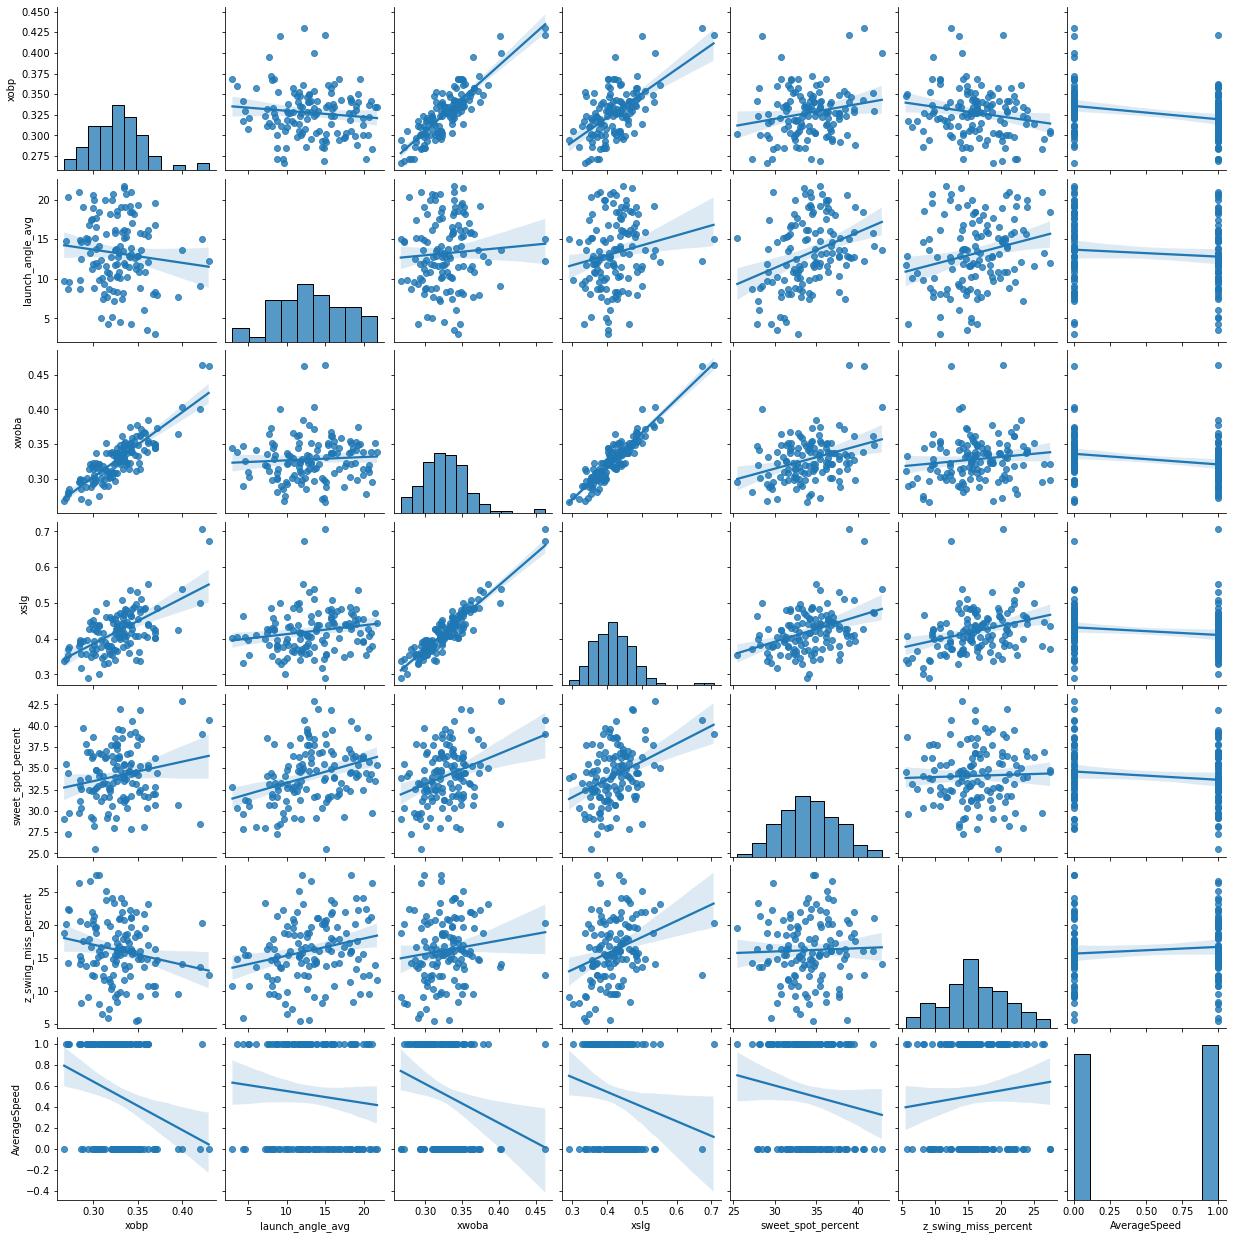

In [27]:
sns.pairplot(ba, vars=['xobp', 'launch_angle_avg', 'xwoba', 'xslg', 'sweet_spot_percent', 'z_swing_miss_percent', 'AverageSpeed'], kind='reg')

In [5]:
xobp = smf.ols(formula='xba ~ xobp', data=ba)
xobp_fit = xobp.fit()
name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(xobp_fit)
print("Linearity Test Results:",['xobp'])
print(list(zip(name, test)))
print("\n")

LAA = smf.ols(formula='xba ~ launch_angle_avg', data=ba)
LAA_fit = LAA.fit()
name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(LAA_fit)
print("Linearity Test Results:",['launch_angle_avg'])
print(list(zip(name, test)))
print("\n")

xwoba = smf.ols(formula='xba ~ xwoba', data=ba)
xwoba_fit = xwoba.fit()
name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(xwoba_fit)
print("Linearity Test Results:",['xwoba'])
print(list(zip(name, test)))
print("\n")

xslg = smf.ols(formula='xba ~ xslg', data=ba)
xslg_fit = xslg.fit()
name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(xslg_fit)
print("Linearity Test Results:",['xslg'])
print(list(zip(name, test)))
print("\n")

AS = smf.ols(formula='xba ~ AverageSpeed', data=ba).fit()
name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(AS)
print("Linearity Test Results:",['AverageSpeed'])
print(list(zip(name, test)))
print("\n")

SSP = smf.ols(formula='xba ~ sweet_spot_percent', data=ba).fit()
name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(SSP)
print("Linearity Test Results:",['sweet_spot_percent'])
print(list(zip(name, test)))
print("\n")

zsmp = smf.ols(formula='xba ~ z_swing_miss_percent', data=ba).fit()
name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(zsmp)
print("Linearity Test Results:",['z_swing_miss_percent'])
print(list(zip(name, test)))
print("\n")

Linearity Test Results: ['xobp']
[('t-stat', 0.543447871655758), ('p-value', 0.5877816675040985)]


Linearity Test Results: ['launch_angle_avg']
[('t-stat', 0.16873426292706833), ('p-value', 0.8662762365630223)]


Linearity Test Results: ['xwoba']
[('t-stat', 0.36100351698937394), ('p-value', 0.7187013815466339)]


Linearity Test Results: ['xslg']
[('t-stat', 0.29674058670392006), ('p-value', 0.7671531656464156)]


Linearity Test Results: ['AverageSpeed']
[('t-stat', 0.7464675672965022), ('p-value', 0.45677555194591446)]


Linearity Test Results: ['sweet_spot_percent']
[('t-stat', 1.1675456782496039), ('p-value', 0.24519474038930197)]


Linearity Test Results: ['z_swing_miss_percent']
[('t-stat', 0.5686250825245491), ('p-value', 0.5706226934008758)]




As all predictors inside the regression fail to reject the null of the Harvey-Collier test, we can assume all present predictors exhibit linearity. If there were predictors that rejected the null of the Harvey-Collier test, we’d use the component+residual/CERES plots to visualize the nonlinear variables and the Box-Tidwell method to linearize each variable.


The regression results would not be interpretable if the variables are non-linear. The Regression expects a linear relationship between the predictors and the dependent variable and including non-linear variables that haven’t been transformed will skew and distort the results of your regression.

### Outliers

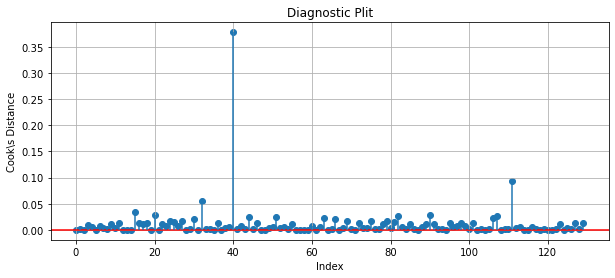

In [7]:
cooks_distance = mr_fit.get_influence().cooks_distance

plt.figure(figsize = (10,4))
plt.scatter(ba.index, cooks_distance[0])
plt.axhline(0, color = 'red')
plt.vlines(x = ba.index, ymin = 0, ymax = cooks_distance[0])
plt.xlabel('Index')
plt.ylabel('Cook\s Distance')
plt.title('Diagnostic Plit')
plt.grid()

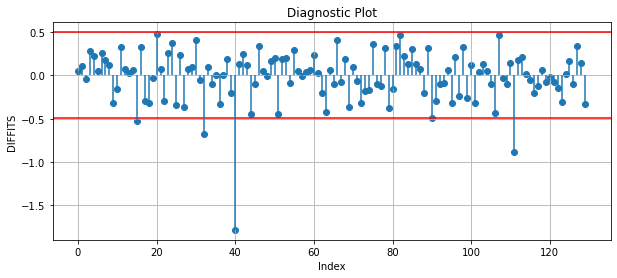

In [5]:
dffits, threshold=mr_fit.get_influence().dffits

plt.figure(figsize=(10,4))
plt.scatter(ba.index,dffits)
plt.axhline(threshold,color='red')
plt.axhline(-threshold,color='red')
plt.vlines(x=ba.index,ymin=0,ymax=dffits)
plt.xlabel('Index')
plt.ylabel('DIFFITS')
plt.title('Diagnostic Plot')
plt.grid()

In [6]:
bav = ba[np.abs(dffits)<threshold]

In [9]:
bav.head()

,last_name,first_name,player_id,year,xba,xslg,xwoba,xobp,xiso,exit_velocity_avg,...,barrel_batted_rate,solidcontact_percent,avg_best_speed,avg_hyper_speed,z_swing_miss_percent,oz_swing_miss_percent,oz_contact_percent,hp_to_1b,sprint_speed,AverageSpeed
0,Cruz Jr.,Nelson,443558,2022,0.241,0.399,0.320,0.323,0.157,90.9,...,9.3,4.5,102.298381,7.468978,23.3,50.6,49.4,4.81,25.5,0.0
1,Blackmon,Charlie,453568,2022,0.256,0.376,0.301,0.308,0.120,86.2,...,4.4,4.0,97.426435,4.732128,16.6,32.6,67.1,4.36,27.9,1.0
2,McCutchen,Andrew,457705,2022,0.252,0.406,0.325,0.329,0.155,89.1,...,8.6,5.8,99.926933,6.143161,16.8,49.2,50.8,4.38,28.9,1.0
3,Turner,Justin,457759,2022,0.267,0.427,0.339,0.343,0.160,89.5,...,8.0,6.2,99.002546,5.736859,16.1,31.1,68.9,4.87,25.0,0.0
4,Andrus,Elvis,462101,2022,0.245,0.360,0.293,0.300,0.114,87.9,...,4.5,3.6,98.336004,5.236648,14.2,36.2,63.8,4.60,26.0,0.0


In [7]:
print("The wage dataset with outliers counted", ba.shape[0], "observations. The new database counts", bav.shape[0], "observations.")
print("Therefore, the significant observations were", ba.shape[0]-bav.shape[0])

The wage dataset with outliers counted 130 observations. The new database counts 126 observations.
Therefore, the significant observations were 4


In [8]:
regr = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=bav)
result = regr.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     79.55
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           1.12e-41
Time:                        14:56:07   Log-Likelihood:                 420.50
No. Observations:                 126   AIC:                            -825.0
Df Residuals:                     118   BIC:                            -802.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1262      0.015      8.517      0.000       0.097       0.156
xobp                     0.8189      0.221      3.708      0.000       0.382       1.256
launch_angle_avg        -0.0021      0.000    -10.083      0.000      -0.002      -0.002
xwoba                   -1.1826      0.411     -2.879      0.005      -1.996      -0.369
xslg                     0.5714      0.136      4.211      0.000       0.303       0.840
sweet_spot_percent       0.0016      0.000      5.753      0.000       0.001       0.002
z_swing_miss_percent    -0.0012      0.000     -5.460      0.000      -0.002      -0.001
AverageSpeed             0.0019      0.002      1.145      0.255      -0.001       0.005
==============================================================================
Omnibus:                        3.662   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.160   Jarque-Bera (JB):                2.225
Skew:                          -0.072   Prob(JB):                        0.329
Kurtosis:                       2.365   Cond. No.                     2.46e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
print("R^2 before removing the observations was:", mr_fit.rsquared)
print("R^2 after removing the observations is:", result.rsquared)
if result.rsquared > mr_fit.rsquared:
    print("The observations were influential")
else:
    print("The observations were not influential")

R^2 before removing the observations was: 0.8145110252354499
R^2 after removing the observations is: 0.8251419135997036
The observations were influential


## MODEL BUIDLING

### Models selection

In [45]:
subdat = bav[['xba', 'xobp', 'launch_angle_avg', 'xwoba', 'xslg', 'sweet_spot_percent', 'z_swing_miss_percent', 'AverageSpeed']].copy()

In [46]:
import itertools

regr = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=bav)
result = regr.fit()
y = bav['xba']
y_pred=result.fittedvalues


storage_cp = pd.DataFrame(columns = ["Variables", "CP"])
k = 8

for L in range(1, len(subdat.columns[1:]) + 1):
    for subset in itertools.combinations(subdat.columns[1:], L):
        
        formula1 = 'xba~'+'+'.join(subset)
        
        result = smf.ols(formula=formula1, data=bav).fit()
        y_sub = result.fittedvalues
        p = len(subset)+1 
        
        cp = mallow.mallow(y, y_pred,y_sub, k, p)
               
        storage_cp = storage_cp.append({'Variables': subset, 'CP': cp}, ignore_index = True)

In [47]:
storage_cp.sort_values(by = "CP")

,Variables,CP
119,"(xobp, launch_angle_avg, xwoba, xslg, sweet_sp...",7.310144
126,"(xobp, launch_angle_avg, xwoba, xslg, sweet_sp...",8.0
104,"(xobp, launch_angle_avg, xslg, sweet_spot_perc...",13.313511
123,"(xobp, launch_angle_avg, xslg, sweet_spot_perc...",14.289172
113,"(launch_angle_avg, xwoba, xslg, sweet_spot_per...",18.51479
...,...,...
1,"(launch_angle_avg,)",460.554843
4,"(sweet_spot_percent,)",466.895103
27,"(z_swing_miss_percent, AverageSpeed)",474.997107
5,"(z_swing_miss_percent,)",490.058095


In [48]:
model = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=bav)
results = model.fit()
y = bav.xba
y_pred=results.fittedvalues

mr_sub = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=bav)
mr_sub_fit = mr_sub.fit()
y_sub=mr_sub_fit.fittedvalues

k = 8
p = 8

mallow.mallow(y, y_pred,y_sub, k, p)

8.0

In [49]:
model = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=bav)
results = model.fit()
y = bav.xba
y_pred=results.fittedvalues

mr_sub = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent', data=bav)
mr_sub_fit = mr_sub.fit()
y_sub=mr_sub_fit.fittedvalues

k = 8
p = 7

mallow.mallow(y, y_pred,y_sub, k, p)

7.310143591915278

In [50]:
model = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=bav)
results = model.fit()
y = bav.xba
y_pred=results.fittedvalues

mr_sub = smf.ols(formula='xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + z_swing_miss_percent', data=bav)
mr_sub_fit = mr_sub.fit()
y_sub=mr_sub_fit.fittedvalues

k = 8
p = 6

mallow.mallow(y, y_pred,y_sub, k, p)

13.313510634845656

In [51]:
model = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=bav)
results = model.fit()
y = bav.xba
y_pred=results.fittedvalues

mr_sub = smf.ols(formula='xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=bav)
mr_sub_fit = mr_sub.fit()
y_sub=mr_sub_fit.fittedvalues

k = 8
p = 7

mallow.mallow(y, y_pred,y_sub, k, p)

14.289172303442626

**Regressions**

In [60]:
# MODEL 1 BENCHMARK: include all the variables
result_bm = smf.ols(formula='xba ~ xobp + launch_angle_avg + + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=bav).fit()
result_bm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     79.55
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           1.12e-41
Time:                        15:35:12   Log-Likelihood:                 420.50
No. Observations:                 126   AIC:                            -825.0
Df Residuals:                     118   BIC:                            -802.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1262      0.015      8.517      0.000       0.097       0.156
xobp                     0.8189      0.221      3.708      0.000       0.382       1.256
launch_angle_avg        -0.0021      0.000    -10.083      0.000      -0.002      -0.002
xwoba                   -1.1826      0.411     -2.879      0.005      -1.996      -0.369
xslg                     0.5714      0.136      4.211      0.000       0.303       0.840
sweet_spot_percent       0.0016      0.000      5.753      0.000       0.001       0.002
z_swing_miss_percent    -0.0012      0.000     -5.460      0.000      -0.002      -0.001
AverageSpeed             0.0019      0.002      1.145      0.255      -0.001       0.005
==============================================================================
Omnibus:                        3.662   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.160   Jarque-Bera (JB):                2.225
Skew:                          -0.072   Prob(JB):                        0.329
Kurtosis:                       2.365   Cond. No.                     2.46e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
# MODEL 2: Exclude AverageSpeed
result2 = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent', data=bav).fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     92.35
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           2.13e-42
Time:                        15:34:16   Log-Likelihood:                 419.80
No. Observations:                 126   AIC:                            -825.6
Df Residuals:                     119   BIC:                            -805.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1304      0.014      9.063      0.000       0.102       0.159
xobp                     0.8003      0.221      3.629      0.000       0.364       1.237
launch_angle_avg        -0.0021      0.000    -10.288      0.000      -0.002      -0.002
xwoba                   -1.1607      0.411     -2.825      0.006      -1.974      -0.347
xslg                     0.5619      0.136      4.143      0.000       0.293       0.830
sweet_spot_percent       0.0016      0.000      5.713      0.000       0.001       0.002
z_swing_miss_percent    -0.0012      0.000     -5.358      0.000      -0.002      -0.001
==============================================================================
Omnibus:                        3.469   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                2.138
Skew:                          -0.062   Prob(JB):                        0.343
Kurtosis:                       2.374   Cond. No.                     2.45e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
# MODEL 3: exclude xwoba and AverageSpeed 
result3 = smf.ols(formula='xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + z_swing_miss_percent', data=bav).fit()
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     103.2
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           9.20e-42
Time:                        15:32:49   Log-Likelihood:                 415.71
No. Observations:                 126   AIC:                            -819.4
Df Residuals:                     120   BIC:                            -802.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1132      0.013      8.441      0.000       0.087       0.140
xobp                     0.1884      0.043      4.402      0.000       0.104       0.273
launch_angle_avg        -0.0021      0.000    -10.025      0.000      -0.003      -0.002
xslg                     0.1840      0.023      8.020      0.000       0.139       0.229
sweet_spot_percent       0.0016      0.000      5.458      0.000       0.001       0.002
z_swing_miss_percent    -0.0014      0.000     -6.534      0.000      -0.002      -0.001
==============================================================================
Omnibus:                        4.469   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                2.705
Skew:                          -0.143   Prob(JB):                        0.259
Kurtosis:                       2.341   Cond. No.                     2.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
# MODEL 4: exclude xwoba  
result4 = smf.ols(formula='xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=bav).fit()
result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     86.15
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           6.12e-41
Time:                        15:32:58   Log-Likelihood:                 416.22
No. Observations:                 126   AIC:                            -818.4
Df Residuals:                     119   BIC:                            -798.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1092      0.014      7.800      0.000       0.081       0.137
xobp                     0.1947      0.043      4.498      0.000       0.109       0.280
launch_angle_avg        -0.0021      0.000     -9.829      0.000      -0.002      -0.002
xslg                     0.1861      0.023      8.075      0.000       0.140       0.232
sweet_spot_percent       0.0016      0.000      5.484      0.000       0.001       0.002
z_swing_miss_percent    -0.0015      0.000     -6.606      0.000      -0.002      -0.001
AverageSpeed             0.0017      0.002      0.982      0.328      -0.002       0.005
==============================================================================
Omnibus:                        4.631   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.099   Jarque-Bera (JB):                2.764
Skew:                          -0.144   Prob(JB):                        0.251
Kurtosis:                       2.334   Cond. No.                     2.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Evaluation of transformation

In [9]:
bacopy = bav.copy()
bacopy = bacopy[["xba", "xobp", "launch_angle_avg", "xwoba", "xslg", "sweet_spot_percent", "z_swing_miss_percent"]]

for i in range(len(bacopy.columns)):
    bc_den, lambda_den = stats.boxcox(abs(bacopy.iloc[:,i]))
    print("lambda for", bacopy.columns[i], ":")
    print(lambda_den)

lambda for xba :
0.7815521917143773
lambda for xobp :
-0.24469628777823632
lambda for launch_angle_avg :
0.9924139319984278
lambda for xwoba :
-0.8021701209556577
lambda for xslg :
-0.378390915770604
lambda for sweet_spot_percent :
0.4976788691298119
lambda for z_swing_miss_percent :
0.9499318331134093


0.7815521917143773


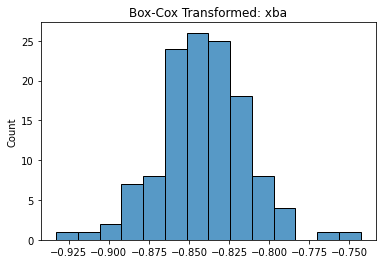

In [10]:
bc_xba, lambda_xba = stats.boxcox(bav["xba"])
print(lambda_xba)
sns.histplot(bc_xba)
plt.title("Box-Cox Transformed: xba")
plt.show()

-0.24469628777823632


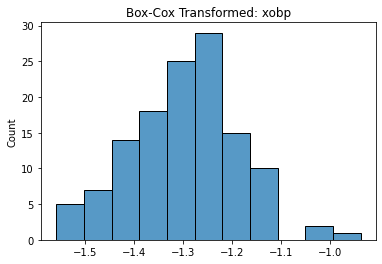

In [11]:
bc_xobp, lambda_xobp = stats.boxcox(bav["xobp"])
print(lambda_xobp)
sns.histplot(bc_xobp)
plt.title("Box-Cox Transformed: xobp")
plt.show()

0.9924139319984278


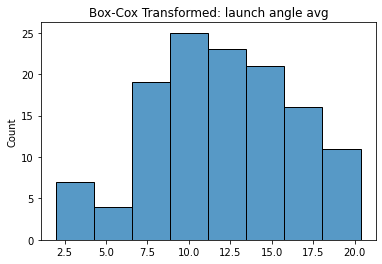

In [12]:
bc_launch_angle_avg, lambda_launch_angle_avg = stats.boxcox(bav["launch_angle_avg"])
print(lambda_launch_angle_avg)
sns.histplot(bc_launch_angle_avg)
plt.title("Box-Cox Transformed: launch angle avg")
plt.show()

-0.8021701209556577


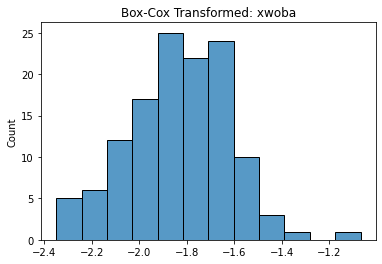

In [13]:
bc_xwoba, lambda_xwoba= stats.boxcox(bav["xwoba"])
print(lambda_xwoba)
sns.histplot(bc_xwoba)
plt.title("Box-Cox Transformed: xwoba")
plt.show()

-0.378390915770604


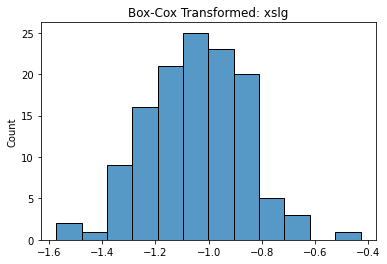

In [14]:
bc_xslg, lambda_xslg= stats.boxcox(bav["xslg"])
print(lambda_xslg)
sns.histplot(bc_xslg)
plt.title("Box-Cox Transformed: xslg")
plt.show()

0.4976788691298119


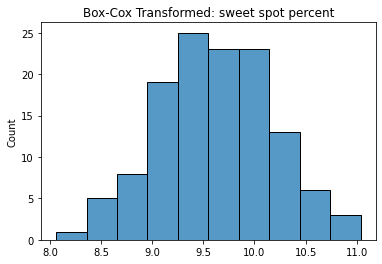

In [15]:
bc_sweet_spot_percent, lambda_sweet_spot_percent = stats.boxcox(bav["sweet_spot_percent"])
print(lambda_sweet_spot_percent)
sns.histplot(bc_sweet_spot_percent)
plt.title("Box-Cox Transformed: sweet spot percent")
plt.show()

0.9499318331134093


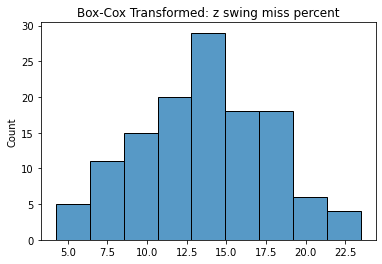

In [16]:
bc_z_swing_miss_percent, lambda_z_swing_miss_percent = stats.boxcox(bav["z_swing_miss_percent"])
print(lambda_z_swing_miss_percent)
sns.histplot(bc_z_swing_miss_percent)
plt.title("Box-Cox Transformed: z swing miss percent")
plt.show()

In [17]:
ba_T = pd.DataFrame(bc_xba, columns = ["xba"])
ba_T["xobp"] = bc_xobp
ba_T["launch_angle_avg"] = bc_launch_angle_avg
ba_T["xwoba"] = bc_xwoba
ba_T["xslg"] = bc_xslg
ba_T["sweet_spot_percent"] = bc_sweet_spot_percent
ba_T["z_swing_miss_percent"] = bc_z_swing_miss_percent
ba_T["AverageSpeed"] = ba.AverageSpeed
ba_T.head()

,xba,xobp,launch_angle_avg,xwoba,xslg,sweet_spot_percent,z_swing_miss_percent,AverageSpeed
0,-0.858724,-1.301814,6.139555,-1.862859,-1.098746,8.541117,19.898183,0.0
1,-0.838391,-1.364881,11.250764,-2.019349,-1.183754,10.061916,14.129226,1.0
2,-0.843787,-1.277600,12.035441,-1.824426,-1.074204,9.979787,14.302930,1.0
3,-0.823646,-1.223178,17.127874,-1.722266,-1.003947,10.684138,13.694503,0.0
4,-0.853276,-1.400101,10.760147,-2.090690,-1.247238,8.745400,12.036186,0.0


In [18]:
ba_T = pd.DataFrame(ba_T, columns = ['xba','xobp','launch_angle_avg', 'xwoba', 'xslg', 'sweet_spot_percent', 'z_swing_miss_percent', 'AverageSpeed'])
ba_T.head()

,xba,xobp,launch_angle_avg,xwoba,xslg,sweet_spot_percent,z_swing_miss_percent,AverageSpeed
0,-0.858724,-1.301814,6.139555,-1.862859,-1.098746,8.541117,19.898183,0.0
1,-0.838391,-1.364881,11.250764,-2.019349,-1.183754,10.061916,14.129226,1.0
2,-0.843787,-1.277600,12.035441,-1.824426,-1.074204,9.979787,14.302930,1.0
3,-0.823646,-1.223178,17.127874,-1.722266,-1.003947,10.684138,13.694503,0.0
4,-0.853276,-1.400101,10.760147,-2.090690,-1.247238,8.745400,12.036186,0.0


**Mallow CP with transformed variables**\
We are going to evaluate whether the best 4 models we picked are going to match with the transformed-Mallow CP.

In [61]:
subdat = ba_T[['xba', 'xobp', 'launch_angle_avg', 'xwoba', 'xslg', 'sweet_spot_percent', 'z_swing_miss_percent', 'AverageSpeed']].copy()

In [62]:
regr = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=ba_T)
result = regr.fit()
y = ba_T['xba']
y_pred=result.fittedvalues


storage_cp = pd.DataFrame(columns = ["Variables", "CP"])
k = 8

for L in range(1, len(subdat.columns[1:]) + 1):
    for subset in itertools.combinations(subdat.columns[1:], L):
        
        formula1 = 'xba~'+'+'.join(subset)
        
        result = smf.ols(formula=formula1, data=ba_T).fit()
        y_sub = result.fittedvalues
        p = len(subset)+1 
        
        cp = mallow.mallow(y, y_pred,y_sub, k, p)
               
        storage_cp = storage_cp.append({'Variables': subset, 'CP': cp}, ignore_index = True)

In [63]:
storage_cp.sort_values(by = "CP").head()

,Variables,CP
119,"(xobp, launch_angle_avg, xwoba, xslg, sweet_sp...",6.00594
126,"(xobp, launch_angle_avg, xwoba, xslg, sweet_sp...",8.0
104,"(xobp, launch_angle_avg, xslg, sweet_spot_perc...",14.394311
123,"(xobp, launch_angle_avg, xslg, sweet_spot_perc...",16.179035
113,"(launch_angle_avg, xwoba, xslg, sweet_spot_per...",20.802362


In [64]:
model = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=ba_T)
results = model.fit()
y = ba_T.xba
y_pred=results.fittedvalues

mr_sub = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=ba_T)
mr_sub_fit = mr_sub.fit()
y_sub=mr_sub_fit.fittedvalues

k = 8
p = 8

mallow.mallow(y, y_pred,y_sub, k, p)

8.0

In [65]:
model = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=ba_T)
results = model.fit()
y = ba_T.xba
y_pred=results.fittedvalues

mr_sub = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent', data=ba_T)
mr_sub_fit = mr_sub.fit()
y_sub=mr_sub_fit.fittedvalues

k = 8
p = 7

mallow.mallow(y, y_pred,y_sub, k, p)

6.005940233404857

In [66]:
model = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=ba_T)
results = model.fit()
y = ba_T.xba
y_pred=results.fittedvalues

mr_sub = smf.ols(formula='xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + z_swing_miss_percent', data=ba_T)
mr_sub_fit = mr_sub.fit()
y_sub=mr_sub_fit.fittedvalues

k = 8
p = 6

mallow.mallow(y, y_pred,y_sub, k, p)

14.394311319733845

In [67]:
model = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=ba_T)
results = model.fit()
y = ba_T.xba
y_pred=results.fittedvalues

mr_sub = smf.ols(formula='xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=ba_T)
mr_sub_fit = mr_sub.fit()
y_sub=mr_sub_fit.fittedvalues

k = 8
p = 7

mallow.mallow(y, y_pred,y_sub, k, p)

16.17903477925239

We confirm the choice of our models.

In [69]:
result_bm_T = smf.ols(formula='xba ~ xobp + launch_angle_avg + + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=ba_T).fit()
result_bm_T.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     80.92
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           4.90e-42
Time:                        16:15:26   Log-Likelihood:                 383.64
No. Observations:                 126   AIC:                            -751.3
Df Residuals:                     118   BIC:                            -728.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.6925      0.030    -23.454      0.000      -0.751      -0.634
xobp                     0.2649      0.065      4.054      0.000       0.135       0.394
launch_angle_avg        -0.0029      0.000    -10.411      0.000      -0.003      -0.002
xwoba                   -0.2019      0.063     -3.190      0.002      -0.327      -0.077
xslg                     0.2238      0.046      4.823      0.000       0.132       0.316
sweet_spot_percent       0.0127      0.002      5.831      0.000       0.008       0.017
z_swing_miss_percent    -0.0020      0.000     -5.653      0.000      -0.003      -0.001
AverageSpeed            -0.0002      0.002     -0.077      0.939      -0.004       0.004
==============================================================================
Omnibus:                        3.373   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                2.143
Skew:                          -0.085   Prob(JB):                        0.342
Kurtosis:                       2.384   Cond. No.                     2.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
result2_T = smf.ols(formula='xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent', data=ba_T).fit()
result2_T.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     95.21
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           4.82e-43
Time:                        16:15:59   Log-Likelihood:                 383.63
No. Observations:                 126   AIC:                            -753.3
Df Residuals:                     119   BIC:                            -733.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.6924      0.029    -23.590      0.000      -0.751      -0.634
xobp                     0.2655      0.065      4.116      0.000       0.138       0.393
launch_angle_avg        -0.0029      0.000    -10.499      0.000      -0.003      -0.002
xwoba                   -0.2025      0.063     -3.237      0.002      -0.326      -0.079
xslg                     0.2242      0.046      4.885      0.000       0.133       0.315
sweet_spot_percent       0.0127      0.002      5.858      0.000       0.008       0.017
z_swing_miss_percent    -0.0020      0.000     -5.696      0.000      -0.003      -0.001
==============================================================================
Omnibus:                        3.416   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                2.155
Skew:                          -0.082   Prob(JB):                        0.341
Kurtosis:                       2.381   Cond. No.                     2.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
result3_T = smf.ols(formula='xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + z_swing_miss_percent', data=ba_T).fit()
result3_T.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     103.9
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           6.54e-42
Time:                        16:16:29   Log-Likelihood:                 378.32
No. Observations:                 126   AIC:                            -744.6
Df Residuals:                     120   BIC:                            -727.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.7315      0.028    -26.337      0.000      -0.787      -0.677
xobp                     0.0614      0.014      4.342      0.000       0.033       0.089
launch_angle_avg        -0.0029      0.000    -10.186      0.000      -0.003      -0.002
xslg                     0.0786      0.009      8.337      0.000       0.060       0.097
sweet_spot_percent       0.0125      0.002      5.525      0.000       0.008       0.017
z_swing_miss_percent    -0.0024      0.000     -6.887      0.000      -0.003      -0.002
==============================================================================
Omnibus:                        5.629   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                3.406
Skew:                          -0.210   Prob(JB):                        0.182
Kurtosis:                       2.312   Cond. No.                         545.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
result4_T = smf.ols(formula='xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=ba_T).fit()
result4_T.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     86.08
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           6.37e-41
Time:                        16:16:57   Log-Likelihood:                 378.42
No. Observations:                 126   AIC:                            -742.8
Df Residuals:                     119   BIC:                            -723.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.7317      0.028    -26.252      0.000      -0.787      -0.676
xobp                     0.0610      0.014      4.295      0.000       0.033       0.089
launch_angle_avg        -0.0029      0.000    -10.148      0.000      -0.003      -0.002
xslg                     0.0786      0.009      8.314      0.000       0.060       0.097
sweet_spot_percent       0.0125      0.002      5.522      0.000       0.008       0.017
z_swing_miss_percent    -0.0024      0.000     -6.878      0.000      -0.003      -0.002
AverageSpeed            -0.0010      0.002     -0.447      0.656      -0.005       0.003
==============================================================================
Omnibus:                        5.172   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                3.300
Skew:                          -0.217   Prob(JB):                        0.192
Kurtosis:                       2.337   Cond. No.                         545.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Transformations, in this, case would not improve our models accuracy and interpretability. Moreover, we would like to preserve the interpretation of our variables. Therefore, we will not used the transformed models.

### Influential observations plot

### Testing multicollinearity

In [75]:
# MODEL 1
y, X1 = pt.dmatrices('xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed',
                    data=bav, return_type='dataframe')

K = X1.shape[1]
VIF = np.empty(K)
for i in range(K):
    VIF[i] = smo.variance_inflation_factor(X1.values, i)
print(f'VIF: \n{VIF}\n')

VIF: 
[350.59993073  58.93040708   1.27300303 231.27470609  93.79190065
   1.36081954   1.85165228   1.15542874]



In [76]:
# MODEL 2
y, X2 = pt.dmatrices('xba ~ xobp + launch_angle_avg + xwoba + xslg + sweet_spot_percent + z_swing_miss_percent',
                    data=bav, return_type='dataframe')

K = X2.shape[1]
VIF = np.empty(K)
for i in range(K):
    VIF[i] = smo.variance_inflation_factor(X2.values, i)
print(f'VIF: \n{VIF}\n')

VIF: 
[329.53271866  58.60986253   1.25393559 230.7766351   93.44328737
   1.35955043   1.82739989]



In [77]:
# MODEL 3
y, X3 = pt.dmatrices('xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + z_swing_miss_percent',
                    data=bav, return_type='dataframe')

K = X3.shape[1]
VIF = np.empty(K)
for i in range(K):
    VIF[i] = smo.variance_inflation_factor(X3.values, i)
print(f'VIF: \n{VIF}\n')

VIF: 
[270.33941023   2.08748062   1.25383895   2.52672659   1.35777406
   1.61557459]



In [83]:
y, X5 = pt.dmatrices('xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + z_swing_miss_percent',
                    data=ba_T, return_type='dataframe')

K = X5.shape[1]
VIF = np.empty(K)
for i in range(K):
    VIF[i] = smo.variance_inflation_factor(X5.values, i)
print(f'VIF: \n{VIF}\n')

VIF: 
[641.18039583   2.02716463   1.2566491    2.50972605   1.35237718
   1.68510884]



In [78]:
# MODEL 4
y, X4 = pt.dmatrices('xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed',
                    data=ba_T, return_type='dataframe')

K = X4.shape[1]
VIF = np.empty(K)
for i in range(K):
    VIF[i] = smo.variance_inflation_factor(X4.values, i)
print(f'VIF: \n{VIF}\n')

VIF: 
[641.25280374   2.03367371   1.26822134   2.51011995   1.35597123
   1.69117524   1.01781104]



### AIC and BIC

In [85]:
print("AIC for model 1 is: ", result_bm.aic)
print("AIC for model 2 is: ", result2.aic)
print("AIC for model 3 is: ", result3.aic)
print("AIC for model 4 is: ", result4.aic)

AIC for model 1 is:  -824.9962955155124
AIC for model 2 is:  -825.6050379209653
AIC for model 3 is:  -819.4243265438613
AIC for model 4 is:  -818.4421969398902


In [86]:
print("BIC for model 1 is: ", result_bm.bic)
print("BIC for model 2 is: ", result2.bic)
print("BIC for model 3 is: ", result3.bic)
print("BIC for model 4 is: ", result4.bic)

BIC for model 1 is:  -802.3060402599006
BIC for model 2 is:  -805.7510645723049
BIC for model 3 is:  -802.4066351021524
BIC for model 4 is:  -798.5882235912298


According to AIC and BIC our best model is Model 2. Model 1 is the second best model. This is different from what the VIF metric was suggesting.\
We still do not know the impact of multicollinearity in our AIC and BIC scores.

*xobp* and *xslg* have high multicollinearity with *xwoba* as can be seen with the VIF. When we remove *xwoba*, the VIF is below the treshold of 4 for all the variables, which helps to mitigate multicollinearity. Therefore, **we decided to consider only model 3 and 4**, despite the results for AIC and BIC telling us that model 1 and 2 are the best. 

### Testing heteroskedasticity

In [89]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(result3.resid, result3.model.exog)
print("BP Results:",['Model 3'])
print(list(zip(name, test)))

BP Results: ['Model 3']
[('Lagrange multiplier statistic', 2.218549021320912), ('p-value', 0.8181522025390319), ('f-value', 0.4301547290867777), ('f p-value', 0.8268494543574764)]


We fail to reject $H_{0}$, therefore, we assume that there is no heteroskedasticity in Model 3.

In [90]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(result4.resid, result4.model.exog)
print("BP Results:",['Model 4'])
print(list(zip(name, test)))

BP Results: ['Model 4']
[('Lagrange multiplier statistic', 1.7991280630387265), ('p-value', 0.9372148334545469), ('f-value', 0.287298358112271), ('f p-value', 0.9419920230929079)]


We fail to reject $H_{0}$, therefore, we assume that there is no heteroskedasticity in Model 4.

### Testing model misspecification

In [92]:
test =  dg.linear_reset(result3, power=2,  test_type='fitted', use_f = True)

print("Ramsey-RESET: Model 1")
print(test)

test =  dg.linear_reset(result4, power=2,  test_type='fitted', use_f = True)

print("Ramsey-RESET: Model 2")
print(test)

Ramsey-RESET: Model 1
<F test: F=1.3669038521132728, p=0.24468114275171823, df_denom=119, df_num=1>
Ramsey-RESET: Model 2
<F test: F=1.468353467712061, p=0.2280265752518757, df_denom=118, df_num=1>


We fail to reject $H_{0}$, therefore, the models are correctly specified as linear.

### Testing interaction 

**Interaction: xslg - sweet spot percent**

In [94]:
result3_int = smf.ols(formula='xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + xslg*sweet_spot_percent + z_swing_miss_percent', data=bav).fit()
result3_int.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     86.73
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           4.42e-41
Time:                        18:08:12   Log-Likelihood:                 416.57
No. Observations:                 126   AIC:                            -819.1
Df Residuals:                     119   BIC:                            -799.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0397      0.059      0.673      0.502      -0.077       0.157
xobp                        0.1867      0.043      4.370      0.000       0.102       0.271
launch_angle_avg           -0.0021      0.000    -10.130      0.000      -0.003      -0.002
xslg                        0.3639      0.143      2.548      0.012       0.081       0.647
sweet_spot_percent          0.0037      0.002      2.188      0.031       0.000       0.007
xslg:sweet_spot_percent    -0.0050      0.004     -1.276      0.204      -0.013       0.003
z_swing_miss_percent       -0.0015      0.000     -6.650      0.000      -0.002      -0.001
==============================================================================
Omnibus:                        3.690   Durbin-Watson:                   2.167
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                2.402
Skew:                          -0.136   Prob(JB):                        0.301
Kurtosis:                       2.381   Cond. No.                     8.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [99]:
# MODEL 3 WITH INTERACTION TERM
y, X5 = pt.dmatrices('xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + xslg*sweet_spot_percent + z_swing_miss_percent',
                    data=bav, return_type='dataframe')

K = X5.shape[1]
VIF = np.empty(K)
for i in range(K):
    VIF[i] = smo.variance_inflation_factor(X5.values, i)
print(f'VIF: \n{VIF}\n')

VIF: 
[5.27404722e+03 2.08965423e+00 1.26749131e+00 9.84473516e+01
 4.69482231e+01 1.92615798e+02 1.63481329e+00]



In [102]:
result4_int = smf.ols(formula='xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + xslg*sweet_spot_percent + z_swing_miss_percent + AverageSpeed', data=bav).fit()
result4_int.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     74.76
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           2.22e-40
Time:                        18:26:41   Log-Likelihood:                 417.29
No. Observations:                 126   AIC:                            -818.6
Df Residuals:                     118   BIC:                            -795.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0263      0.060      0.438      0.662      -0.093       0.145
xobp                        0.1940      0.043      4.499      0.000       0.109       0.279
launch_angle_avg           -0.0021      0.000     -9.958      0.000      -0.003      -0.002
xslg                        0.3878      0.144      2.691      0.008       0.102       0.673
sweet_spot_percent          0.0039      0.002      2.326      0.022       0.001       0.007
xslg:sweet_spot_percent    -0.0056      0.004     -1.418      0.159      -0.014       0.002
z_swing_miss_percent       -0.0015      0.000     -6.760      0.000      -0.002      -0.001
AverageSpeed                0.0020      0.002      1.162      0.247      -0.001       0.006
==============================================================================
Omnibus:                        3.727   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                2.385
Skew:                          -0.126   Prob(JB):                        0.304
Kurtosis:                       2.375   Cond. No.                     8.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
# MODEL 4 WITH INTERACTION TERM
y, X6 = pt.dmatrices('xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + xslg*sweet_spot_percent + z_swing_miss_percent + AverageSpeed',
                    data=bav, return_type='dataframe')

K = X6.shape[1]
VIF = np.empty(K)
for i in range(K):
    VIF[i] = smo.variance_inflation_factor(X6.values, i)
print(f'VIF: \n{VIF}\n')

VIF: 
[5.47670188e+03 2.13477290e+00 1.28271121e+00 1.00490814e+02
 4.77891341e+01 1.95910629e+02 1.67345312e+00 1.17266229e+00]



**Interaction: launch angle average - sweet spot percent**

In [100]:
result3_int2 = smf.ols(formula='xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + sweet_spot_percent*launch_angle_avg + z_swing_miss_percent', data=bav).fit()
result3_int2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     85.79
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           7.48e-41
Time:                        18:25:32   Log-Likelihood:                 416.01
No. Observations:                 126   AIC:                            -818.0
Df Residuals:                     119   BIC:                            -798.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.0924      0.031      2.995      0.003       0.031       0.153
xobp                                    0.1881      0.043      4.386      0.000       0.103       0.273
launch_angle_avg                       -0.0005      0.002     -0.213      0.832      -0.005       0.004
xslg                                    0.1841      0.023      8.012      0.000       0.139       0.230
sweet_spot_percent                      0.0022      0.001      2.452      0.016       0.000       0.004
sweet_spot_percent:launch_angle_avg -4.889e-05   6.54e-05     -0.747      0.456      -0.000    8.06e-05
z_swing_miss_percent                   -0.0014      0.000     -6.519      0.000      -0.002      -0.001
==============================================================================
Omnibus:                        5.625   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                3.141
Skew:                          -0.159   Prob(JB):                        0.208
Kurtosis:                       2.294   Cond. No.                     2.82e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [104]:
# MODEL 3 WITH INTERACTION TERM 2
y, X7 = pt.dmatrices('xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + sweet_spot_percent*launch_angle_avg + z_swing_miss_percent',
                    data=bav, return_type='dataframe')

K = X7.shape[1]
VIF = np.empty(K)
for i in range(K):
    VIF[i] = smo.variance_inflation_factor(X7.values, i)
print(f'VIF: \n{VIF}\n')

VIF: 
[1426.30493831    2.08769414  137.10159501    2.52699498   13.26123586
  176.07050956    1.61559127]



In [105]:
result4_int2 = smf.ols(formula='xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + sweet_spot_percent*launch_angle_avg + z_swing_miss_percent + AverageSpeed', data=bav).fit()
result4_int2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     73.60
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           4.66e-40
Time:                        18:30:25   Log-Likelihood:                 416.48
No. Observations:                 126   AIC:                            -817.0
Df Residuals:                     118   BIC:                            -794.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.0898      0.031      2.899      0.004       0.028       0.151
xobp                                    0.1942      0.043      4.476      0.000       0.108       0.280
launch_angle_avg                       -0.0005      0.002     -0.246      0.806      -0.005       0.004
xslg                                    0.1861      0.023      8.062      0.000       0.140       0.232
sweet_spot_percent                      0.0022      0.001      2.416      0.017       0.000       0.004
sweet_spot_percent:launch_angle_avg -4.599e-05   6.55e-05     -0.702      0.484      -0.000    8.37e-05
z_swing_miss_percent                   -0.0015      0.000     -6.585      0.000      -0.002      -0.001
AverageSpeed                            0.0017      0.002      0.946      0.346      -0.002       0.005
==============================================================================
Omnibus:                        5.750   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                3.176
Skew:                          -0.158   Prob(JB):                        0.204
Kurtosis:                       2.289   Cond. No.                     2.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [106]:
# MODEL 4 WITH INTERACTION TERM 2
y, X8 = pt.dmatrices('xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + sweet_spot_percent*launch_angle_avg + z_swing_miss_percent + AverageSpeed',
                    data=bav, return_type='dataframe')

K = X8.shape[1]
VIF = np.empty(K)
for i in range(K):
    VIF[i] = smo.variance_inflation_factor(X8.values, i)
print(f'VIF: \n{VIF}\n')

VIF: 
[1.43757268e+03 2.13503718e+00 1.37267785e+02 2.54851698e+00
 1.32775551e+01 1.76455896e+02 1.64702906e+00 1.15546400e+00]



**Interaction: xslg - xobp**

In [107]:
result3_int3 = smf.ols(formula='xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + xobp*xslg + z_swing_miss_percent', data=bav).fit()
result3_int3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     86.19
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           5.99e-41
Time:                        18:38:53   Log-Likelihood:                 416.25
No. Observations:                 126   AIC:                            -818.5
Df Residuals:                     119   BIC:                            -798.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0662      0.049      1.365      0.175      -0.030       0.162
xobp                     0.3254      0.143      2.279      0.024       0.043       0.608
launch_angle_avg        -0.0021      0.000    -10.065      0.000      -0.003      -0.002
xslg                     0.3020      0.120      2.525      0.013       0.065       0.539
sweet_spot_percent       0.0016      0.000      5.451      0.000       0.001       0.002
xobp:xslg               -0.3362      0.334     -1.006      0.317      -0.998       0.326
z_swing_miss_percent    -0.0015      0.000     -6.600      0.000      -0.002      -0.001
==============================================================================
Omnibus:                        4.376   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                2.741
Skew:                          -0.160   Prob(JB):                        0.254
Kurtosis:                       2.352   Cond. No.                     1.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [108]:
# MODEL 3 WITH INTERACTION TERM 3
y, X9 = pt.dmatrices('xba ~ xobp + launch_angle_avg + xslg + xobp*xslg + sweet_spot_percent + z_swing_miss_percent',
                    data=bav, return_type='dataframe')

K = X9.shape[1]
VIF = np.empty(K)
for i in range(K):
    VIF[i] = smo.variance_inflation_factor(X9.values, i)
print(f'VIF: \n{VIF}\n')

VIF: 
[3.54489827e+03 2.32176553e+01 1.25754289e+00 6.87155456e+01
 1.28930252e+02 1.35785345e+00 1.68803332e+00]



In [110]:
result4_int2 = smf.ols(formula='xba ~ xobp + launch_angle_avg + xslg + sweet_spot_percent + xslg + xobp*xslg + z_swing_miss_percent + AverageSpeed', data=bav).fit()
result4_int2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    xba   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     74.04
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           3.51e-40
Time:                        18:41:14   Log-Likelihood:                 416.79
No. Observations:                 126   AIC:                            -817.6
Df Residuals:                     118   BIC:                            -794.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0608      0.049      1.246      0.215      -0.036       0.158
xobp                     0.3358      0.143      2.346      0.021       0.052       0.619
launch_angle_avg        -0.0021      0.000     -9.872      0.000      -0.002      -0.002
xslg                     0.3076      0.120      2.569      0.011       0.070       0.545
sweet_spot_percent       0.0016      0.000      5.478      0.000       0.001       0.002
xobp:xslg               -0.3459      0.334     -1.034      0.303      -1.008       0.316
z_swing_miss_percent    -0.0015      0.000     -6.678      0.000      -0.002      -0.001
AverageSpeed             0.0018      0.002      1.012      0.314      -0.002       0.005
==============================================================================
Omnibus:                        4.529   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                2.778
Skew:                          -0.156   Prob(JB):                        0.249
Kurtosis:                       2.343   Cond. No.                     1.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [109]:
# MODEL 4 WITH INTERACTION TERM 3
y, X10 = pt.dmatrices('xba ~ xobp + launch_angle_avg + xslg + xobp*xslg + sweet_spot_percent + z_swing_miss_percent + AverageSpeed',
                    data=bav, return_type='dataframe')

K = X10.shape[1]
VIF = np.empty(K)
for i in range(K):
    VIF[i] = smo.variance_inflation_factor(X10.values, i)
print(f'VIF: \n{VIF}\n')

VIF: 
[3.58816406e+03 2.33387478e+01 1.27598410e+00 6.88596653e+01
 1.29035333e+02 1.35896832e+00 1.72213979e+00 1.15388010e+00]



### Robustness

### Cross-validation

### Out of sample performance

### Marginal effects

### Model issues

## CONCLUSION

### Economic interpretation of the results